In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

WORKDIR = Path(os.getcwd()).parent.absolute().as_posix()
RANDOM_STATE = 42

os.environ["WORKDIR"] = WORKDIR
sys.path.append(WORKDIR)

In [3]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import shap

from models.perceptron import PerceptronRegressor

sns.set_theme()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Download data 
__Source__: https://archive.ics.uci.edu/dataset/9/auto+mpg

In [4]:
# %%bash
# wget -O $WORKDIR/data/auto+mpg.zip https://archive.ics.uci.edu/static/public/9/auto+mpg.zip
# unzip -o -q $WORKDIR/data/auto+mpg.zip -d $WORKDIR/data

# Read data and preprocess data

In [33]:
def read_data(path: str) -> pd.DataFrame:
    """
    Read data using the given path.
    """

    column_names = [
        "mpg",
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "origin",
        "car_name"
    ]
    lines = []
    with open(path, "r") as fp:
        for line in fp:
            l, car_name = line.rstrip('\n').split("\t")
            
            lines.append(l.split() + [car_name.replace(f'"', "")])

    df = pd.DataFrame(lines, columns=column_names)

    return df 


def cast_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    dtype = {
        "mpg": float,
        "cylinders": float,
        "displacement": float,
        "horsepower": float,
        "weight": float,
        "acceleration": float,
        "model_year": float,
        "origin": float,
        "car_name": str
    }

    df["horsepower"] = df["horsepower"].replace({"?": np.nan})

    df = df.astype(dtype)

    return df


def drop_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["car_name"])
    return df


def fill_na(df: pd.DataFrame) -> pd.DataFrame:
    df["horsepower"].fillna(df["horsepower"].median(), inplace=True)
    df["log_horsepower"].fillna(df["log_horsepower"].median(), inplace=True)

    return df
    

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = cast_dtypes(df)
    df = drop_cols(df)

    return df

In [23]:
data = read_data(f"{WORKDIR}/data/auto-mpg.data")
data = preprocess_data(data)

# Visualization analysis and feature engineering

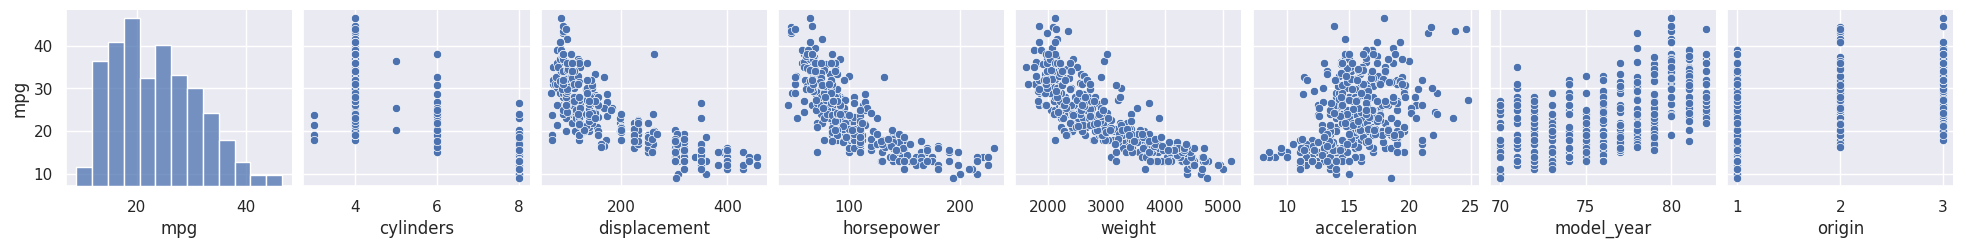

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.pairplot(data, y_vars=["mpg"])

Add new feature: `log_horsepower`.

# Train-test splitting

In [25]:
y = data["mpg"]
X = data.drop(columns=["mpg"])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)
X_train = fill_na(X_train)
X_test = fill_na(X_test)

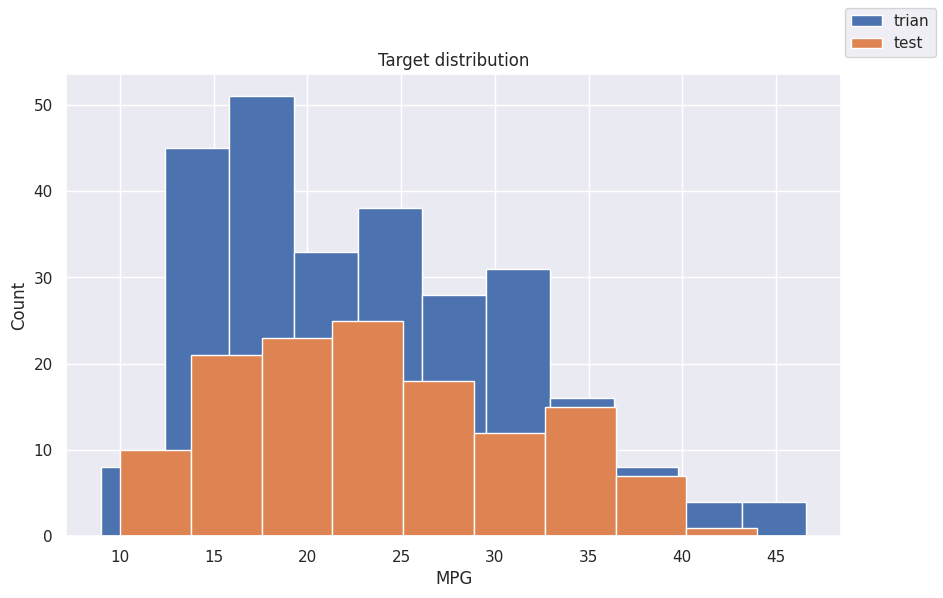

In [35]:
fig = plt.figure(figsize=(10, 6))

plt.hist(y_train, bins="auto", label="trian")
plt.hist(y_test, bins="auto", label="test")
plt.title("Target distribution")
plt.xlabel("MPG")
plt.ylabel("Count")
fig.legend()

# Ridge, Lasso and Perceptron with hyperparameter tunning on Cross Validation

## Ridge pipeline

In [36]:
grid_params = {
    "alpha": np.linspace(0.01, 5, 10)
}
grid = GridSearchCV(Ridge(), grid_params, scoring="r2", cv=5, verbose=1, refit=True)

ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("regressor", grid)
])
_ = ridge.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## Lasso pipeline

In [37]:
grid_params = {
    "alpha": np.linspace(0.01, 5, 10)
}
grid = GridSearchCV(Lasso(), grid_params, scoring="r2", cv=5, verbose=1, refit=True)

lasso = Pipeline([
    ("scaler", MinMaxScaler()),
    ("regressor", grid)
])
_ = lasso.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [38]:
lasso_coef = lasso["regressor"].best_estimator_.coef_

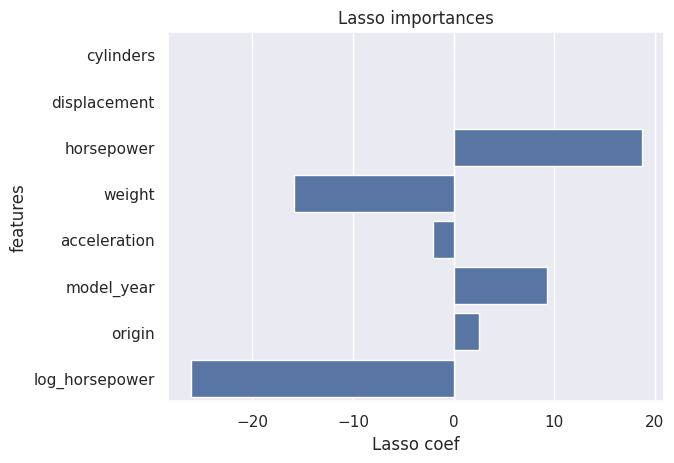

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    palette=sns.color_palette(n_colors=1)

    ax = sns.barplot(x=lasso_coef, y=X_train.columns, palette=palette)
    ax.set_xlabel("Lasso coef")
    ax.set_ylabel("features")
    ax.set_title("Lasso importances")

__NB.__  L1 regularization gives us a tool for feature selection. Using it we get the most important features: `log_horsepower`, `horsepower`, `weight`, `model_year` and `origin`.

## Perceptron pipeline

In [40]:
perceptron = Pipeline([
    ("scaler", MinMaxScaler()),
    ("regressor", PerceptronRegressor(learning_rate=0.01, epochs=1000))
])
_ = perceptron.fit(X_train, y_train)

# Model comparisons

In [41]:
metrics = []
for name, model in [("ridge", ridge), ("lasso", lasso), ("perceptron", perceptron)]:
    y_pred = model.predict(X_test)
    metric = {}
    metric["model"] = name
    metric["mae"] = mae(y_test, y_pred)
    metric["mse"] = mse(y_test, y_pred)
    metric["R2"] = model.score(X_test, y_test)

    metrics.append(metric)
    
pd.DataFrame(metrics)

,model,mae,mse,R2
0,ridge,1.995996,6.755625,0.882627
1,lasso,2.052658,6.805584,0.881759
2,perceptron,2.023045,6.787453,0.882074


__Conclusion.__ Ridge regression work a little bit better.

# Permutation importance analysis

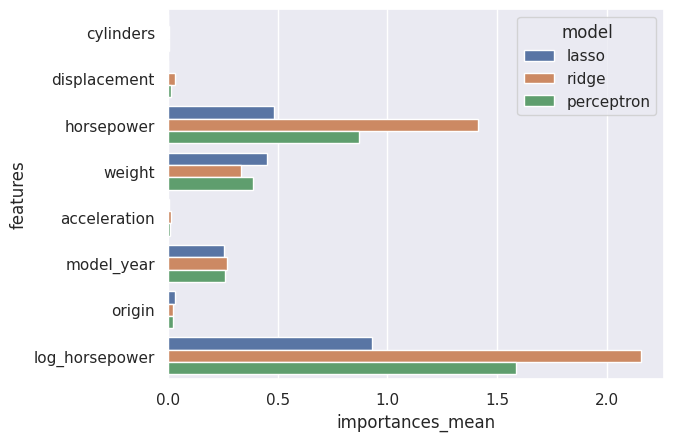

In [42]:
lasso_imp = permutation_importance(lasso, X_train, y_train, n_repeats=10, random_state=RANDOM_STATE)
ridge_imp = permutation_importance(ridge, X_train, y_train, n_repeats=10, random_state=RANDOM_STATE)
perceptron_imp = permutation_importance(perceptron, X_train, y_train, n_repeats=10, random_state=RANDOM_STATE)

n = len(X_train.columns)
imp_data = [
    pd.DataFrame({
        "model": ["lasso"] * n,
        "features": X_train.columns,
        "importances_mean": lasso_imp["importances_mean"], 
        "importances_std": lasso_imp["importances_std"]
    }),
    pd.DataFrame({
        "model": ["ridge"] * n,
        "features": X_train.columns,
        "importances_mean": ridge_imp["importances_mean"], 
        "importances_std": ridge_imp["importances_std"]
    }),
    pd.DataFrame({
        "model": ["perceptron"] * n, 
        "features": X_train.columns,
        "importances_mean": perceptron_imp["importances_mean"], 
        "importances_std": perceptron_imp["importances_std"]
    })
]
imp_data = pd.concat(imp_data, ignore_index=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    palette=sns.color_palette(n_colors=1)

    sns.barplot(data=imp_data, x="importances_mean", y="features", hue="model")

__Conclusion.__ As we can see the most important features are `log_horsepower`, `horsepower`, `wight`, `model_year`, `origin`.

# SHAP analysis

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


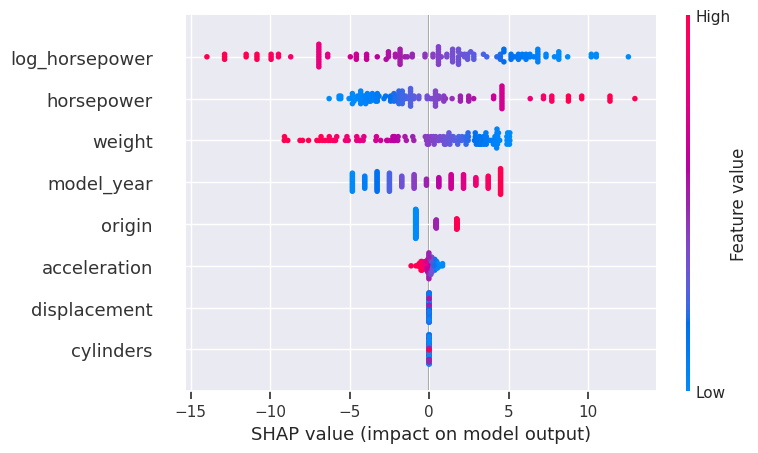

In [43]:
masker = lasso["scaler"].transform(X_test)
masker = pd.DataFrame(masker, columns=lasso["scaler"].feature_names_in_)
explainer = shap.LinearExplainer(lasso["regressor"].best_estimator_, masker)
shap_values = explainer.shap_values(masker)
shap.summary_plot(shap_values, masker)

__Conclusion.__ As we can see the most important features are also `log_horsepower`, `horsepower`, `wight`, `model_year`, `origin`. In addition, we can say that
1. higher `weight` or `log_horsepower` -> lower `mpg` and vice versa;
2. higher `model_year` or `origin` or `horsepower` -> higher `mpg`, lower `model_year` or `origin` or `horsepower` -> lower `mpg`. 